<div align="center">

###### ***Assignment 1: by Jonaz Juan Sayson and Fabiola Villanueva***

### **"<u>Balanced Risk Set Matching</u>"**
by Yunfei Paul Li, Kathleen J. Propert, and Paul R. Rosenbaum

</div>

<div style="text-align: justify;">

##### **Introduction**

The journal introduces a new matching method that is applied in an observational study to assess a treatment, cystoscopy and hydrodistension - **to create balanced comparison groups when random assignment is not possible**.

*The article "Balanced Risk Set Matching" was published in the Journal of the American Statistical Association (JASA). It is a peer-reviewed journal that publishes articles on statistical theory and methods, applications, and data science. The journal has both print (ISSN: 0162-1459) and online (ISSN: 1537-274X) versions. The JASA's focus is on original and important contributions to statistical methods, practice, and theory.*

##### **Key Concept**

The key idea for BRSM is that when **patient A is given treatment at a certain time *t*, patient A is matched to patient B with similar history of symptoms up to time *t*** - wherein patient B has not received the treatment up until time *t*.

##### **Methodology**

A treatment is studied for a chronic disease called **Interstitial Cystitis**. The treatment is called **cystoscopy and hydrodistention**, and it’s <u>given to patients based on their symptoms</u>. To understand if the treatment works, we compare patients who received it to similar patients who didn’t.

1. **Risk Set Matching**
	- When a patient gets treatment at a specific time, we find another patient who had similar symptoms up to that point but didn't get the treatment; **finding treated and untreated patients with similar symptoms** - matching patients.
2. **Balancing Symptoms**
	- How do we exactly know that the untreated and treated patients have **similar symptom patterns?** - **integer programming**.
3. **Choosing the Best Matches**
	- Treated and untreated patients with similar symptom patterns are then narrowed down further by **selecting a group based off of similarity in attributes**.
4. **Checking for Hidden Biases**
	- Results are then tested in the matter of sensitivity from hidden factors that could affect on who gets the treatment. **A standard way to check for these biases must be shown w/o biases** that shall suit best for this study.

> <u>***Key Words for Query***</u>
>
> Integer programming? Matched sampling? Network flow? Observational study? Sensitivity analysis?

Patients with similar symptom patterns (using **risk set matching**) are grouped into "treated" (those who received the treatment) and "untreated" (those who didn’t) - take note of the time these patients are diagnosed. To make the groups as similar as possible, patients are further matched based on their characteristics (like age, health history, etc.) using a math technique called **integer programming**. The results are tested to ensure they’re not skewed by hidden biases, making the findings more trustworthy.

</div>

---
<div align="center">

### **"Matching to Achieve Comparable Histories"**

##### **Observational Study of <u>Interstitial Cystitis</u>**

</div>

<div style="text-align: justify;">

This study **looks at how a surgical procedure called cystoscopy and hydrodistension affects the symptoms of Interstitial Cystitis** (IC), a chronic condition causing bladder pain and frequent, urgent urination. Unlike a urinary tract infection, **IC has no evidence of infection, and its causes and progression are not well understood**.

In an ideal scenario, the effectiveness of a treatment would be tested in a randomized controlled trial, where **patients are randomly assigned to either receive the treatment or not**. This ensures that the groups being compared are similar before treatment. However, in real-world settings, especially with chronic diseases like IC, randomized trials aren't always possible due to ethical or practical reasons. Instead, **treatments are often given based on the severity of symptoms**, which can **make it harder to compare treated and untreated patients fairly**.

This study uses data from the Interstitial Cystitis Data Base (ICDB), which tracked patients with IC symptoms (like urinary urgency, frequency, and pelvic pain) for up to 4 years. Patients were evaluated every 3 months, and three key symptoms were measured: **pain, urgency, and nighttime urination frequency**. Pain and urgency were rated on a scale from 0 to 9, with higher numbers indicating worse symptoms.

Patients in the database were treated according to standard clinical practices, and some underwent cystoscopy and hydrodistension, likely due to severe or worsening symptoms. The study aims to understand how this surgical intervention impacts IC symptoms over time, even though the treatment wasn't randomly assigned.

> <u>***What are the procedures involved in the journal?***</u>
> 
>**Balanced Risk Set Matching** is **performed using a new algorithm to achieve similar patients** in each pair and balanced groups in aggregate.
>
>**Optimal balanced matching** is conducted **to minimize the total distance within matched pairs**. This involves finding a balanced pair matching M that minimizes the total distance across all balanced pair matchings. This can be achieved through integer programming methods.
> 
>**Minimum cost flow in a network** is used for **optimal pair matching**.
>
>**Sensitivity analysis** is conducted **to assess how hidden biases might alter the conclusions** of the observational study. This involves a parameter that describes the magnitude of departure from a randomised experiment.
>
>**Permutation inference** is used, which **involves risk set matching to justify simple, conventional permutation inferences** under a general model for the decision to apply the treatment at a particular moment in response to time-varying symptoms.
>
>**Integer programming** is used, where **the optimal balanced matching problem is expressed as minimizing a linear function of integer variables**, subject to linear equality and inequality constraints. The balance conditions are treated as a penalty in the objective function.

</div>

##### ***Procedures***

In [3]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import linear_sum_assignment
from sklearn.preprocessing import StandardScaler

# load the dataset
df = pd.read_csv('./Datasets/patient_treatment_data.csv')

---
<div align="center">

### **Risk Set Matching**

</div>

<div style="text-align: justify;">

As mentioned earlier, Risk Set Matching is when a patient receives treatment at a a certain time, we then find following:
- patients with **similar pain score, urgency score, and frequency score**
- **untreated and treated patients** at the time of treatment of the current patient

This is comparing an individual who experiences an event at time_t to all other individual at risk of the event at time_t.

***Steps*** 
1. **Separate the treated and untreated patients** into two groups (yes/no).
2. Match the patients based on symptoms by **finding untreated patients with the closest symptoms scores**.
3. Use a distance metric for a matching algorithm - Euclidean Distance model

### **Euclidean Distance Model**
- Calculates the Euclidean distance between two rows(patients) base on specific columns(symptom scores).
- It measures the similarity betwen patients based on their symptom scores.

</div>

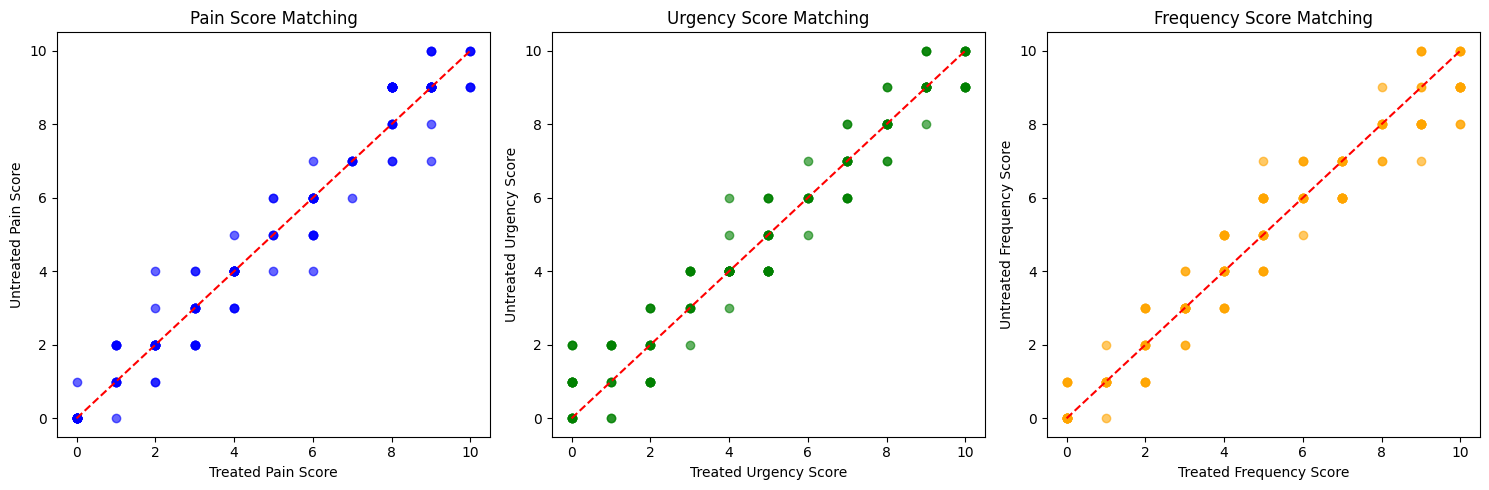

In [ ]:
# Display first few rows to verify
df.head()

# Convert Treatment_Time to datetime
df['Treatment_Time'] = pd.to_datetime(df['Treatment_Time'])

# Separate treated and untreated patients
treated = df[df['Treated'] == 'Yes']
untreated = df[df['Treated'] == 'No']

# Function to calculate Euclidean distance
def euclidean_distance(row1, row2, columns):
    return np.sqrt(np.sum((row1[columns] - row2[columns]) ** 2))

# Function to perform risk set matching with time constraint
def risk_set_matching(treated, untreated, symptom_columns):
    matches = []
    
    for _, treated_patient in treated.iterrows():
        min_distance = float('inf')
        closest_untreated = None
        
        # Filter untreated patients who were untreated at the time of treatment
        untreated_at_risk = untreated[untreated['Treatment_Time'].isna() | (untreated['Treatment_Time'] > treated_patient['Treatment_Time'])]
        
        # Find the closest untreated patient based on symptom scores
        for _, untreated_patient in untreated_at_risk.iterrows():
            distance = euclidean_distance(treated_patient, untreated_patient, symptom_columns)
            if distance < min_distance:
                min_distance = distance
                closest_untreated = untreated_patient
        
        # Record the match
        if closest_untreated is not None:
            matches.append({
                'Treated_ID': treated_patient['ID'],
                'Treated_Pain_Score': treated_patient['Pain_Score'],
                'Treated_Urgency_Score': treated_patient['Urgency_Score'],
                'Treated_Frequency_Score': treated_patient['Frequency_Score'],
                'Treated_Treatment_Time': treated_patient['Treatment_Time'],
                'Untreated_ID': closest_untreated['ID'],
                'Untreated_Pain_Score': closest_untreated['Pain_Score'],
                'Untreated_Urgency_Score': closest_untreated['Urgency_Score'],
                'Untreated_Frequency_Score': closest_untreated['Frequency_Score'],
                'Untreated_Treatment_Time': closest_untreated['Treatment_Time']
            })
    
    return pd.DataFrame(matches)

# Define the symptom columns to match on
symptom_columns = ['Pain_Score', 'Urgency_Score', 'Frequency_Score']

# Perform risk set matching
matched_pairs = risk_set_matching(treated, untreated, symptom_columns)

# Display the matched pairs
# print(":: MATCHED PAIRS")
# print(matched_pairs)

# Visualization
plt.figure(figsize=(15, 5))

# Plot Pain_Score
plt.subplot(1, 3, 1)
plt.scatter(matched_pairs['Treated_Pain_Score'], matched_pairs['Untreated_Pain_Score'], color='blue', alpha=0.6)
plt.plot([0, 10], [0, 10], 'r--')  # Diagonal line for reference
plt.title('Pain Score Matching')
plt.xlabel('Treated Pain Score')
plt.ylabel('Untreated Pain Score')

# Plot Urgency_Score
plt.subplot(1, 3, 2)
plt.scatter(matched_pairs['Treated_Urgency_Score'], matched_pairs['Untreated_Urgency_Score'], color='green', alpha=0.6)
plt.plot([0, 10], [0, 10], 'r--')  # Diagonal line for reference
plt.title('Urgency Score Matching')
plt.xlabel('Treated Urgency Score')
plt.ylabel('Untreated Urgency Score')

# Plot Frequency_Score
plt.subplot(1, 3, 3)
plt.scatter(matched_pairs['Treated_Frequency_Score'], matched_pairs['Untreated_Frequency_Score'], color='orange', alpha=0.6)
plt.plot([0, 10], [0, 10], 'r--')  # Diagonal line for reference
plt.title('Frequency Score Matching')
plt.xlabel('Treated Frequency Score')
plt.ylabel('Untreated Frequency Score')

plt.tight_layout()
plt.show()

---
<div align="center">

### **Optimal Balanced Matching**

</div>

<div style="text-align: justify;">

This refers to a new form of matching used in observational studies that aims to achieve two goals:
1. match similar patients in each pair
2. create balanced treated and control groups in aggregate

Specifically, Optimal Balanced Matching involves:

**Risk set matching**: When a patient receives treatment at time t, they are matched to another patient with a similar history of symptoms up to time t who has not received the treatment up to time t.

**Balancing**: Using a penalty function in integer programming to force the marginal distributions of symptoms to be balanced in the matched treated and control groups.

**Optimization**: Among all balanced matchings, selecting the one that minimizes the multivariate pretreatment covariate distance within matched pairs.

***Steps***

1. **Define the Pool**: Identify the group of patients you're working with, those who received the treatment, and the possible pairings between treated and untreated individuals.

2. **Define Covariates**: Select a set of K binary variables that describe the covariates to be balanced.

3. **Assess Similarity**: Determine how to measure the distance/similarity between potential matches. Mahalanobis distance is a common choice.

4. **Balance the Groups**: Use a penalty function within an integer programming framework to force the marginal distributions of the covariates to be balanced in the matched treated and control groups.

5. **Optimize the Matching**: Use minimum cost flow in a network to find the optimal matching that minimizes the total distance within pairs while satisfying the balance requirements.

### **Hungarian Algorithm**

The Hungarian algorithm is **a combinatorial optimization algorithm that solves the assignment problem in polynomial time**. It is used to find the optimal assignment of tasks to agents (or, in this case, treated patients to untreated patients) such that the total cost (or distance) is minimized.

> ***How does it work?***
>
> **Cost Matrix**: A matrix is created where each row represents a treated patient, each column represents an untreated patient, and each cell contains the cost (or distance) of matching that treated patient to that untreated patient.
>
>**Row and Column Reduction**: Subtract the smallest value in each row from all elements in that row. Subtract the smallest value in each column from all elements in that column.
>
>**Covering Zeros**: Find the minimum number of lines (rows or columns) needed to cover all zeros in the matrix.
>
>**Optimal Assignment**: If the number of lines equals the number of rows (or columns), an optimal assignment exists. Otherwise, adjust the matrix and repeat the process.
>
>**Result**: The algorithm returns the optimal assignment of treated patients to untreated patients that minimizes the total cost.

In the context of this journal's Optimal Balance Matching, the algorithm is used as the following:

1. **Match Treated and Untreated Patients**: Each treated patient is matched to an untreated patient based on their symptom scores (e.g., Pain_Score, Urgency_Score, Frequency_Score).

2. **Minimize Total Distance**: The algorithm ensures that the total Euclidean distance between matched pairs is minimized.

3. **Ensure One-to-One Matching**: Each treated patient is matched to exactly one untreated patient, and vice versa.

</div>

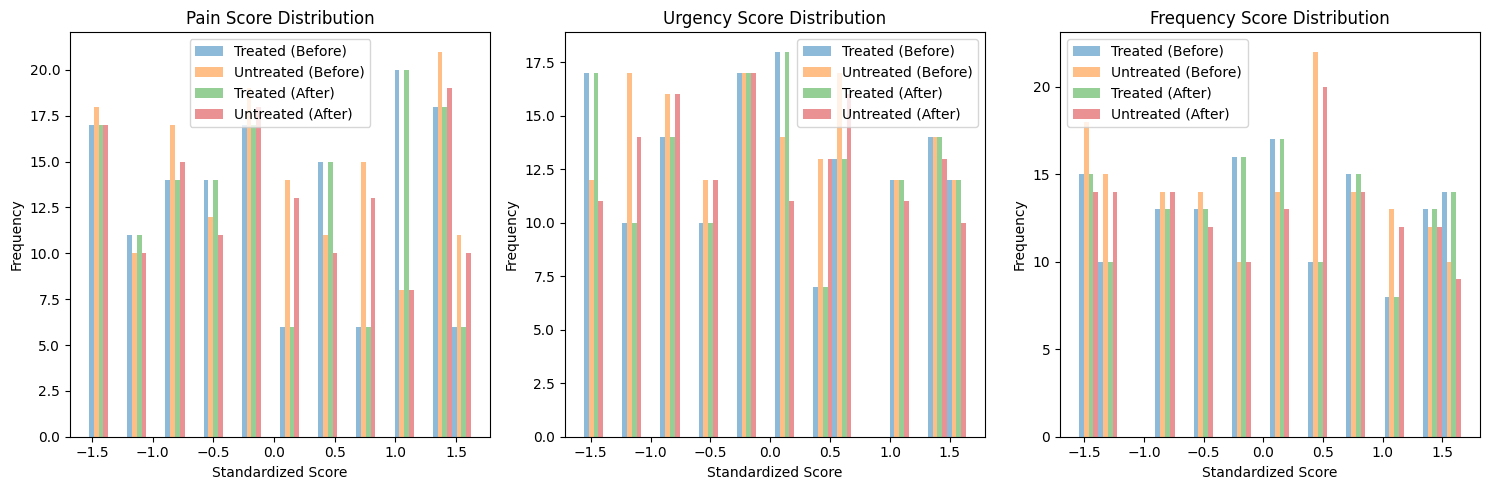

In [5]:
# Convert Treatment_Time to datetime
df['Treatment_Time'] = pd.to_datetime(df['Treatment_Time'])

# Separate treated and untreated patients
treated = df[df['Treated'] == 'Yes']
untreated = df[df['Treated'] == 'No']

# Define the symptom columns to match on
symptom_columns = ['Pain_Score', 'Urgency_Score', 'Frequency_Score']

# Standardize the symptom scores for distance calculation
scaler = StandardScaler()
df[symptom_columns] = scaler.fit_transform(df[symptom_columns])

# Function to calculate Euclidean distance
def euclidean_distance(row1, row2, columns):
    return np.sqrt(np.sum((row1[columns] - row2[columns]) ** 2))

# Function to perform optimal balanced matching
def optimal_balanced_matching(treated, untreated, symptom_columns):
    # Create a cost matrix
    cost_matrix = np.zeros((len(treated), len(untreated)))
    
    # Calculate pairwise distances
    for i in range(len(treated)):
        for j in range(len(untreated)):
            treated_patient = treated.iloc[i]
            untreated_patient = untreated.iloc[j]
            cost_matrix[i, j] = euclidean_distance(treated_patient, untreated_patient, symptom_columns)
    
    # Use the Hungarian algorithm to find the optimal matching
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Create the optimized matched pairs
    optimized_matches = []
    for i, j in zip(row_ind, col_ind):
        treated_patient = treated.iloc[i]
        untreated_patient = untreated.iloc[j]
        optimized_matches.append({
            'Treated_ID': treated_patient['ID'],
            'Treated_Pain_Score': treated_patient['Pain_Score'],
            'Treated_Urgency_Score': treated_patient['Urgency_Score'],
            'Treated_Frequency_Score': treated_patient['Frequency_Score'],
            'Treated_Treatment_Time': treated_patient['Treatment_Time'],
            'Untreated_ID': untreated_patient['ID'],
            'Untreated_Pain_Score': untreated_patient['Pain_Score'],
            'Untreated_Urgency_Score': untreated_patient['Urgency_Score'],
            'Untreated_Frequency_Score': untreated_patient['Frequency_Score'],
            'Untreated_Treatment_Time': untreated_patient['Treatment_Time']
        })
    
    return pd.DataFrame(optimized_matches)

# Perform optimal balanced matching
optimized_matched_pairs = optimal_balanced_matching(treated, untreated, symptom_columns)

# Display the optimized matched pairs
# print(":: OPTIMIZED MATCHED PAIRS")
# print(optimized_matched_pairs)

# Visualization: Compare distributions before and after matching using histograms
plt.figure(figsize=(15, 5))

# Plot Pain_Score distribution
plt.subplot(1, 3, 1)
plt.hist([treated['Pain_Score'], untreated['Pain_Score'], optimized_matched_pairs['Treated_Pain_Score'], optimized_matched_pairs['Untreated_Pain_Score']], 
         bins=20, alpha=0.5, label=['Treated (Before)', 'Untreated (Before)', 'Treated (After)', 'Untreated (After)'], rwidth=1.0)
plt.title('Pain Score Distribution')
plt.xlabel('Standardized Score')
plt.ylabel('Frequency')
plt.legend()

# Plot Urgency_Score distribution
plt.subplot(1, 3, 2)
plt.hist([treated['Urgency_Score'], untreated['Urgency_Score'], optimized_matched_pairs['Treated_Urgency_Score'], optimized_matched_pairs['Untreated_Urgency_Score']], 
         bins=20, alpha=0.5, label=['Treated (Before)', 'Untreated (Before)', 'Treated (After)', 'Untreated (After)'], rwidth=1.0)
plt.title('Urgency Score Distribution')
plt.xlabel('Standardized Score')
plt.ylabel('Frequency')
plt.legend()

# Plot Frequency_Score distribution
plt.subplot(1, 3, 3)
plt.hist([treated['Frequency_Score'], untreated['Frequency_Score'], optimized_matched_pairs['Treated_Frequency_Score'], optimized_matched_pairs['Untreated_Frequency_Score']], 
         bins=20, alpha=0.5, label=['Treated (Before)', 'Untreated (Before)', 'Treated (After)', 'Untreated (After)'], rwidth=1.0)
plt.title('Frequency Score Distribution')
plt.xlabel('Standardized Score')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

---
### **Minimum Cost Flow in a Network**

---
### **Sensitivity Analysis**

---
### **Permutation Inference**

---
### **Integer Programming**